INFO:base_node_rpc.proxy:Successfully connected to dropbot on port COM16


base_node_software_version                                                     
package_name                                                            dropbot
display_name                                                            DropBot
manufacturer                                                        Wheeler Lab
url                           http://github.com/wheeler-microfluidics/dropbo...
software_version                                                            1.9
dtype: object

uuid			0000816f-0700-db9e-1640-0f00454e0237

i2c_scan: [10 32 33 34 80]
soft_i2c_scan: [44]
number of channels: 120

config:
max_voltage                        150
R7                             8565.72
min_frequency                      100
switching_board_i2c_address         32
max_frequency                    10000
pot_max                        48700.5
i2c_address                         10
id                                    
dtype: object
rms_error = 3.5%


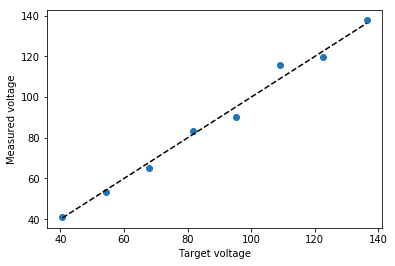

In [5]:
import logging; logging.basicConfig(level=logging.DEBUG)
import time

from dropbot import SerialProxy
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

try:
    del proxy
except:
    pass

# Connect to the connected DropBot and print it's properties
proxy = SerialProxy()

print proxy.properties

print "\nuuid\t\t\t%s\n" % proxy.uuid

#proxy.reset_config()
proxy.update_config(max_voltage=150, i2c_address=10)

print "i2c_scan:", proxy.i2c_scan()
print "soft_i2c_scan:", proxy.soft_i2c_scan()

proxy.initialize_switching_boards()

print "number of channels:", proxy.number_of_channels

print "\nconfig:"
print proxy.config

# test the measured voltage for a range of target voltages
proxy.voltage = proxy.min_waveform_voltage
proxy.hv_output_enabled = True
measured_voltage = []

voltage = np.linspace(proxy.min_waveform_voltage,
                      proxy.max_waveform_voltage,
                      10)[1:-1]
for v in voltage:
    proxy.voltage = v
    time.sleep(.5)
    measured_voltage.append(proxy.measured_voltage)

measured_voltage = np.array(measured_voltage)
proxy.voltage = proxy.min_waveform_voltage + 5

plt.figure()
# plot the measured vs target votage
plt.plot(voltage, measured_voltage, 'o')
plt.plot(voltage, voltage, 'k--')
plt.xlabel('Target voltage')
plt.ylabel('Measured voltage')

# calculate the average rms error
r = measured_voltage - voltage
print 'rms_error = %.1f%%' % (100 * np.sqrt(np.mean((r / voltage)**2)))

In [6]:
channel_selection = widgets.SelectMultiple(options=range(proxy.number_of_channels),
                                           style={'height': '500px'},
                                           description='Channels:',
                                           disabled=False)
def set_actuated_channels(message):
    c = proxy.select_on_board_test_capacitor(-1)
    states = np.zeros(proxy.number_of_channels)
    states[message.get('new', [])] = 1
    proxy.state_of_channels = states
    
# Start with all channels off.
proxy.hv_output_enabled = True
proxy.state_of_channels = np.zeros(proxy.number_of_channels)
channel_selection.observe(set_actuated_channels, names='value', type='change')

channel_selection

In [155]:
# Turn off all channels
proxy.state_of_channels = np.zeros(proxy.number_of_channels)